# Assignment 2 - Classification of Business Reviews

**Submission deadline: Friday 26 April 2019, 11pm**

**Penalty for late submission: 4 marks per day**

**Assessment marks: 20 marks (20% of the total unit assessment)**

In this assignment you will design and evaluate several deep learning models that predict user ratings of restaurents given their reviews. **Note that, depending on the hardware of your machine, the running time of the training process may vary**. In particular:

* If your machine does not have a Graphics Processing Unit (GPU), every epoch may run for 30 seconds or longer. **For the exercise that uses LSTM, every epoch may run for 5 minutes or longer**.
* If your machine has a GPU and Keras is configured to use the GPU, every epoch may run for 5 to 10 seconds. **For the exercise that uses LSTM, every epoch may still run for 2 minutes or longer**.

**You are advised to start early and not to leave the exercises to the last minute since the total running time of the code may take over an hour**, and you may need to run parts of the code several times for testing and debugging.

The following code reads business reviews which are part of the [Yelp Dataset stored in Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset). The data are stored in a CSV file. The following code reads the CSV file and prints the contents of the first 5 records:

In [1]:
import pandas as pd
pd_data = pd.read_csv('yelp_review.zip')
pd_data[:5]

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


From the data, we will only use the reviews and the star rating. The following code extracts this information and places it in a list of pairs:

In [2]:
all_data = list(zip(pd_data['text'], pd_data['stars']))

In [3]:
len(all_data)

5261668

In [4]:
all_data[:5]

[("Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly.",
  5),
 ("Small unassuming place that changes their menu every so often. Cool decor and vibe inside their 30 seat restaurant. Call for a reservation. \n\nWe had their beef tartar and pork belly to start and a salmon dish and lamb meal for mains. Everything was incredible! I could go on at length about how all the listed ingredients really make their dishes amazing but honestly you just need to go. \n\nA bit outside of downtown montreal but take the metro out and it's less than a 10 minute walk from the station.",
  5),
 ("Lester's is located in a beautiful neighborhood and has been there since 1951. They are known for smoked meat which most deli's have but their brisket sandwich is what I come to montreal for. They've got about 12 seats outside to go along with the insi

Let's now check the distribution of star ratings:

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

In [6]:
from collections import Counter
c = Counter([rating for text, rating in all_data])
c

Counter({5: 2253347, 4: 1223316, 3: 615481, 1: 731363, 2: 438161})

<BarContainer object of 5 artists>

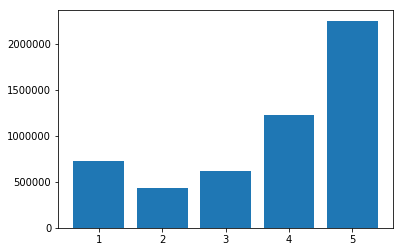

In [7]:
plt.bar(range(1,6), [c[1], c[2], c[3], c[4], c[5]])

The data set is fairly large with more than 5 million samples. To speed up the computations for this assigmnent, we will use 500,000 samples for training, 10,000 for the dev-test set and 10,000 for the test set. To reduce any possible bias while partitioning the data set, we will first shuffle the data and then partition into training data, dev-test data, and test data using the following code:


In [8]:
import random
random.seed(1234)
random.shuffle(all_data)
train_data, devtest_data, test_data = all_data[:500000], all_data[500000:510000], all_data[510000:520000]

The following code uses Keras' `Tokenizer` to convert the train, devtest, and test data into matrices of indices. We use only the 10,000 most frequent words of the training set. Note how we use the text of the training set to fit the tokenizer *before* attempting to tokenize any of the texts.

In [9]:
num_words = 10000 # Use this to inform the tokenizer what is the maximum number of words.

In [10]:
import keras
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts([d for d, l in train_data])

In [13]:
train_sequences = tokenizer.texts_to_sequences([d for d, l in train_data])

In [14]:
devtest_sequences = tokenizer.texts_to_sequences([d for d, l in devtest_data])

In [15]:
test_sequences = tokenizer.texts_to_sequences([d for d, l in test_data])

The following code plots a histogram with the lengths of all reviews.

(array([284620., 134588.,  47083.,  18197.,   7775.,   3619.,   1772.,
           961.,    575.,    810.]),
 array([1.0000e+00, 5.0550e+02, 1.0100e+03, 1.5145e+03, 2.0190e+03,
        2.5235e+03, 3.0280e+03, 3.5325e+03, 4.0370e+03, 4.5415e+03,
        5.0460e+03]),
 <a list of 10 Patch objects>)

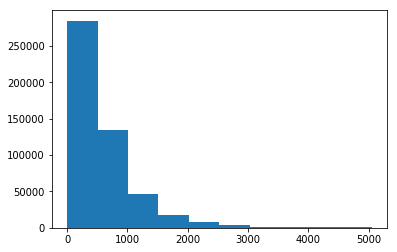

In [16]:
plt.hist([len(d) for d, l in train_data])

We can see that there are many fairly long reviews. To facilitate the assignment we will truncate the reviews using Keras' `pad_sequences`. The following code will select the last 100 words of each review:

In [17]:
train_vectors = pad_sequences(train_sequences, maxlen=100)

In [18]:
devtest_vectors = pad_sequences(devtest_sequences, maxlen=100)

In [19]:
test_vectors = pad_sequences(test_sequences, maxlen=100)

## Task 1 (1 mark)
Design a neural model that has the following sequence of layers:
* An embedding layer that generates embeddings with 50 dimensions.
* A layer that flattens the output of the previous layer.
* A dense layer with 50 nodes and a `relu` activation.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                250050    
Total params: 750,050
Trainable params: 750,050
Non-trainable params: 0
_________________________________________________________________


## Task 2 (1 mark)
This is multi-class classification since we want to predict the review score. This means that the label needs to be converted into 5 outputs using one-hot encoding. Write Python code that converts the training, devtest, and test data to the appropriate encoding.

In [21]:
# Write your code so that one_hot_train_labels has the one_hot encoding of the train labels

one_hot_train_labels[:10]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [22]:
# Write your code so that one_hot_devtest_labels has the one_hot encoding of the devtest labels

one_hot_devtest_labels[:10]

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [23]:
# Write your code so that one_hot_test_labels has the one_hot encoding of the test labels

one_hot_test_labels[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## Task 3 (1 mark)
Complete the design of the model by providing the correct output layer for this task. Compile the model by providing the appropriate loss function and the `accuracy` evaluation metric. Use `rmsprop` as the optimizer.

## Task 4 (1 mark)
Train the model using 20 epochs and batch size of 512. Use the devtest set to determine the accuracy at each epoch.

Train on 500000 samples, validate on 10000 samples
Epoch 1/20
500000/500000 [==============================] - 25s 51us/step - loss: 0.8575 - acc: 0.6360 - val_loss: 0.8062 - val_acc: 0.6515
Epoch 2/20
500000/500000 [==============================] - 28s 55us/step - loss: 0.7641 - acc: 0.6772 - val_loss: 0.8063 - val_acc: 0.6540
Epoch 3/20
500000/500000 [==============================] - 29s 57us/step - loss: 0.7063 - acc: 0.7073 - val_loss: 0.8353 - val_acc: 0.6458
Epoch 4/20
500000/500000 [==============================] - 29s 58us/step - loss: 0.6397 - acc: 0.7414 - val_loss: 0.8846 - val_acc: 0.6342
Epoch 5/20
500000/500000 [==============================] - 21s 42us/step - loss: 0.5748 - acc: 0.7730 - val_loss: 0.9542 - val_acc: 0.6213
Epoch 6/20
500000/500000 [==============================] - 19s 38us/step - loss: 0.5162 - acc: 0.8005 - val_loss: 1.0453 - val_acc: 0.6032
Epoch 7/20
500000/500000 [==============================] - 20s 40us/step - loss: 0.4640 - acc: 0.8239 - val_

## Task 5 (1 mark)
Given the results that you observed in the previous question, train the model again, now using a better choice of number of epochs.

## Task 6 (1 mark)
Given the results you obtained, comment whether there was overfitting. Explain your conclusions.

*(Write your answer here)*

## Task 7 (3 marks)
Now, use the average of embeddings instead of the `Flat` layer. You can do this by replacing the `Flat` layer with `GlobalAveragePooling1D`. Answer the following questions.
1. How many epochs do you need to train the network? Explain how you decided the number of epochs.
2. Is there overfitting? Explain why.
3. Are the results better or worse?

## Task 8 (3 marks)
Instead of averaging the word embeddings, now introduce a recurrent layer with LSTM cells. Conduct an analysis of the results similar to the one in the previous task. Feel free to add additional comments to your analysis.

## Task 9 (8 marks)
This final task is open-ended. Try to improve the system, and write below the code of your experiments and your results. Explain what you do to try to improve the results, what worked and what did not work.

Some strategies that may work:
* Change the number of hidden cells, change the number of hidden layers.
* Change the number of words per sentence. Currently it's 100 (but note that this will make the system slower).
* Use different features. For example you could try with tf.idf.
* Use pre-trained word embeddings.

For this exercise, it is important that you document what you are doing and explain your reasoning. We will value a good explanation, good error analysis and good motivation. You may obtain top marks even if your system did not do well, provided that your report in this section is sound. But you may obtain low marks in this exercise if the system does well but the report is of poor quality.

The rubric for assessing this exercise is as follows:
* Correct code (3 marks).
* Sound methodology and evaluation (3 marks).
* Sound explanations (2 marks).

# Submission of Results

Your submission should consist of this Jupyter notebook with all your code and explanations inserted into the notebook. The notebook should contain the output of the runs.

Examine the cells of this notebook so that you can have an idea of how to format text for good visual impact. You can also read this [useful guide to the MarkDown notation](http://daringfireball.net/projects/markdown/syntax), which explains the format of the text.

Late submissions will have a penalty of **4 marks deduction per day late**.

Each question specifies a mark. The final mark of the assignment is the sum of all the individual marks, after applying any deductions for late submission.

By submitting this assignment you are acknowledging that this is your own work. Any submissions that break the code of academic honesty will be penalised as per [the academic integrity policy](https://staff.mq.edu.au/work/strategy-planning-and-governance/university-policies-and-procedures/policies/academic-integrity).
